# 03 — LSTM Forecasting with TensorFlow/Keras

**Goal:** Build an **LSTM** to forecast 1‑step ahead values for the energy proxy series.

**You will learn:**
- Turning a univariate price series into supervised sequences.
- Defining and training a compact LSTM.
- Evaluating and visualizing predictions.

> On Apple Silicon, if `pip install tensorflow` fails, try `pip install tensorflow-macos`.


## 0) Setup & Imports

In [1]:
# If needed, install (uncomment)
# %pip install yfinance pandas numpy matplotlib scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True

print("TensorFlow:", tf.__version__)


TensorFlow: 2.16.2


## 1) Download data

In [3]:
TICKER = "XLE"
df = yf.download(TICKER, start="2015-01-01", auto_adjust=True).reset_index()
df = df[["Date", "Close"]].dropna().reset_index(drop=True)
df.head()


[*********************100%***********************]  1 of 1 completed


Price,Date,Close
Ticker,,XLE
0,2015-01-02,52.311001
1,2015-01-05,50.147003
2,2015-01-06,49.410316
3,2015-01-07,49.515553
4,2015-01-08,50.627151


## 2) Create supervised sequences

In [4]:
WINDOW = 22
values = df["Close"].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

def make_sequences(series, window):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)

X, y = make_sequences(scaled, WINDOW)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2121, 22, 1), (531, 22, 1), (2121, 1), (531, 1))

Time series are naturally **sequential**: each observation depends on the past.  
However, neural networks like **LSTM/GRU** do not directly understand raw 1D sequences — they expect **supervised learning data** with inputs (X) and targets (y).  

To bridge this, we reframe the series into a supervised problem:
- **Input (X):** a rolling window of past observations (e.g., last 22 days of trading).  
- **Target (y):** the next value after the window (the “tomorrow” price).  

Formally:
$X_t = \{ Y_{t-22}, Y_{t-21}, ..., Y_{t-1} \}, \quad y_t = Y_t$

This way, the model learns:  
*"Given the last 22 timesteps, what is the next value?"*

This is known as the **sliding window method** and is the standard approach for preparing sequential data for deep learning.

---

### What we do
1. **Scaling the series**  
   - We use `MinMaxScaler` to map prices into `[0, 1]`.  
   - Why? Neural nets converge faster and more stably when inputs are on a small, consistent range.

2. **Building sequences**  
   - With `WINDOW = 20`, we slide a 22-day window across the series.  
   - Each window (`X`) contains 22 values, the corresponding target (`y`) is the 23rd value.  
   - The function `make_sequences()` automates this rolling process.

3. **Train/Test split**  
   - First 80% of the sequences → training.  
   - Last 20% → testing.  
   - Important: no random shuffling! In time series we preserve chronology to avoid **data leakage**.

4. **Final shapes**  
   - `X_train.shape = (n_train, 22, 1)` → each sample has 30 timesteps and 1 feature.  
   - `y_train.shape = (n_train, 1)` → one target value per sequence.  
   - This matches the expected input for LSTM/GRU: `(batch, timesteps, features)`.

---

### Why this matters
- We convert an **unsupervised 1D time series** into a **supervised learning dataset**.  
- The LSTM/GRU can now capture **temporal dependencies** in electricity prices.  
- Window size (22) reflects ~1 trading month of history, but can be tuned depending on the dataset and domain knowledge.  

In short:  


We are teaching the model to “read” the past 22 days of prices like a sentence, and predict the next word (price).

## 3) Define & train the LSTM

In [5]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.summary()

es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)


2025-08-21 12:40:50.680712: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-08-21 12:40:50.685130: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-08-21 12:40:50.686230: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-08-21 12:40:50.686585: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-21 12:40:50.686794: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/matteodimauro/miniconda3/envs/electricity/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. W

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-08-21 12:40:52.009895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0144 - val_loss: 0.0105
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1733e-04 - val_loss: 0.0035
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4294e-04 - val_loss: 0.0015
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4425e-04 - val_loss: 0.0019
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2277e-04 - val_loss: 0.0015
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.0156e-04 - val_loss: 0.0018
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9267e-04 - val_loss: 0.0014
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.6959e-04 - val_loss: 0.0014
Epoch 9/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.6238e-04 - val_loss: 0.0014
Epoch 10/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4596e-04 - val_loss: 0.0016
Epoch 11/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3594e-04 - val_loss: 0.0012
Epoch 12/200
53/53 ━━━━━━━━━━━━━━━

Now that we transformed the time series into supervised sequences, we can train a **Recurrent Neural Network (RNN)** model.  
Specifically, we use an **LSTM (Long Short-Term Memory)** layer, which is designed to capture **temporal dependencies** in sequential data like financial prices.

#### Theory
- **LSTM** networks extend classic RNNs by including memory cells and gates that control the flow of information.  
- This makes them capable of learning both **short-term** and **long-term** patterns (e.g., daily volatility vs. monthly cycles).  
- Here, the network learns to map an input window of size **22 trading days (≈ 1 month)** to the next-day price.  
- The training objective is **Mean Squared Error (MSE)**, which penalizes large forecast errors.

Formally:  
$
X_t = \{ Y_{t-22}, Y_{t-21}, ..., Y_{t-1} \}, \quad y_t = Y_t
$

#### Model Architecture
- **LSTM(64)**: 64 hidden units (memory cells) process the 22-day input sequence.  
- **Dense(1)**: a single output neuron predicting the next normalized price.  
- **Optimizer:** Adam (adaptive learning rate).  
- **Loss:** MSE (suitable for regression tasks).  

#### Early Stopping
- To avoid **overfitting**, we monitor the validation loss.  
- If it doesn’t improve for 10 consecutive epochs, training stops.  
- The best weights are restored automatically.

#### Training
- **Epochs:** up to 200 (but may stop earlier thanks to early stopping).  
- **Batch size:** 32 (number of sequences processed together).  
- **Validation split:** 20% of the training set is used to evaluate performance during training.  

In practice: the model is trained step by step on historical rolling windows of 22 trading days, learning how to forecast the price on the 23rd day.

## 4) Evaluate & visualize

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
LSTM | RMSE: 1.1540815193990333 MAE: 0.8492838972705903 MAPE%: 1.0005322933887162


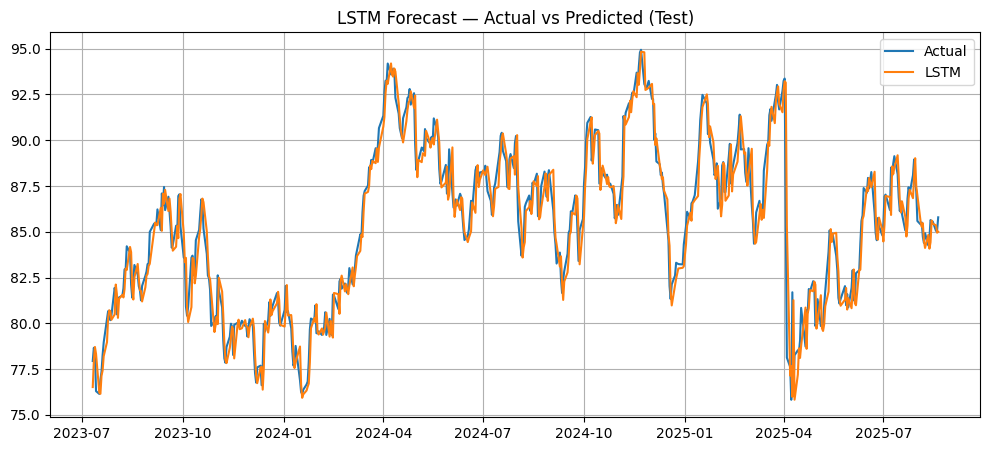

In [6]:
y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print("LSTM | RMSE:", rmse, "MAE:", mae, "MAPE%:", mape)

plt.figure()
plt.plot(df["Date"].values[-len(y_test_inv):], y_test_inv, label="Actual")
plt.plot(df["Date"].values[-len(y_test_inv):], y_pred_inv, label="LSTM")
plt.title("LSTM Forecast — Actual vs Predicted (Test)")
plt.legend(); plt.show()


The LSTM model shows a **very close alignment** between actual values and predictions on the test set, as seen in the plot.  
This suggests that the recurrent structure of the network is successfully capturing temporal dependencies in the financial series.

**Evaluation Metrics (Test Set):**
- **RMSE:** 1.15  
- **MAE:** 0.85  
- **MAPE:** 1.00%  

Interpretation:
- The **low RMSE and MAE** indicate that the absolute prediction errors remain small in magnitude.  
- The **MAPE of ~1%** highlights that the model’s relative error compared to the actual price is minimal, showing strong predictive accuracy.  
- Visually, the forecast line (orange) almost overlaps the actual price (blue), confirming the numerical metrics.  

Compared to ARIMA and LightGBM, from the previous notebooks, the LSTM achieves **much lower errors**, especially in terms of percentage accuracy, making it the best-performing model so far in this pipeline.

## 5) Next steps

- Try different `WINDOW` sizes and batch sizes.
- Add **exogenous features** (e.g., natural gas `NG=F`) as additional input channels.
- Perform **walk‑forward retraining** to simulate live operation.
- Compare LSTM vs ARIMA vs LightGBM on the same rolling split.
